In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from functools import reduce

import torch

from transformers import MusicgenForConditionalGeneration, AutoProcessor

from captum.concept import TCAV
from captum.attr import LayerGradientXActivation

from src.tcav.model import MusicGenWithGrad, NetClassifier, SVMClassifier
from src.tcav.concept import create_experimental_set
from src.data.text_conditioning import TextConditioning
from captum.concept._utils.common import concepts_to_str

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

random_state = 42
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(random_state)

torch.set_grad_enabled(True)

/home/bruno/miniconda3/envs/music-gen-interpretability/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
# from datasets import load_dataset
# from transformers import AutoProcessor, EncodecModel

# dataset = load_dataset("hf-internal-testing/ashraq-esc50-1-dog-example")
# audio_sample = dataset["train"]["audio"][0]["array"]

# model_id = "facebook/encodec_24khz"
# model = EncodecModel.from_pretrained(model_id)
# processor = AutoProcessor.from_pretrained(model_id)

# inputs = processor(raw_audio=audio_sample, return_tensors="pt")

# outputs = model(**inputs)
# audio_codes = outputs.audio_codes
# audio_values = outputs.audio_values
# print(audio_values.shape, audio_codes.shape)

In [3]:
processor = AutoProcessor.from_pretrained("facebook/musicgen-small")
model = MusicgenForConditionalGeneration.from_pretrained("facebook/musicgen-small")
model.to(device)
model = model.half()  # Convert model weights to float16
model.eval()

MusicgenForConditionalGeneration(
  (text_encoder): T5EncoderModel(
    (shared): Embedding(32128, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
                (wo): L

In [4]:
music_genres = [
    "pop",
    "rock",
    "jazz",
    "classical",
    "hip-hop",
    "country",
    "electronic",
    "reggae",
    "blues",
    "folk",
    "r&b",
    "metal",
    "punk",
    "soul",
    "gospel",
    "latin",
    "reggaeton",
    "disco",
    "indie",
    "alternative",
    "house",
    "techno",
    "trance",
    "dubstep",
    "ambient",
    "new age",
    "bluegrass",
    "grunge",
    "emo",
    "post-rock",
    "post-punk",
    "shoegaze",
    "industrial",
    "experimental",
    "noise",
    "synthwave",
    "chillwave",
    "lo-fi",
    "acoustic",
    "instrumental",
    "soundtrack",
    "world",
    "funk",
    "swing",
    "bossa nova",
    "k-pop",
    "j-pop",
    "c-pop",
    "t-pop",
    "amapiano",
    "afrobeats",
    "dancehall",
    "trap",
    "grime",
    "drum and bass",
    "dub",
    "salsa",
]

In [5]:
instruments = [
    "guitar",
    "piano",
    "drums",
    "bass",
    "strings",
    "voice",
    "keyboard",
    "synth",
    "violin",
    "saxophone",
    "choir",
    "trumpet",
    "flute",
    "clarinet",
    "trombone",
    "cello",
    "harp",
    "accordion",
    "synthesizer",
    "turntables",
    "theremin",
    "ukulele",
    "banjo",
    "mandolin",
    "marimba",
    "percussion",
    "harmonica",
    "didgeridoo",
    "bagpipes",
    "sitar",
    "tabla",
    "hats",
    "kick",
    "snare",
    "tom",
    "djembe",
    "bongos",
    "conga",
    "timbales",
    "steel drum",
    "kalimba",
    "zither",
    "ocarina",
    "bassoon",
    "oboe",
    "horn",
]

In [6]:
emotions = [
    "happy",
    "sad",
    "angry",
    "relaxed",
    "excited",
    "nostalgic",
    "romantic",
    "melancholic",
    "energetic",
    "calm",
    "mysterious",
    "joyful",
    "hopeful",
    "intense",
    "peaceful",
    "reflective",
    "playful",
    "dramatic",
    "eerie",
    "triumphant",
    "depressed",
    "anxious",
    "confident",
    "powerful",
    "moody",
]

In [7]:
data_module = TextConditioning(
    dataset="google/MusicCaps",
    processor=processor,
    influential_concept_category="instrument",
    influential_concept_name="guitar",
    target_concept_category="genre",
    target_concept_name="rock",
    batch_size=10,
    device=device,
    genres=music_genres,
    instruments=instruments,
    emotions=emotions
)
custom_model = MusicGenWithGrad(model=model, processor=processor)

experimental_set_size = 3
num_samples = 10

/home/bruno/miniconda3/envs/music-gen-interpretability/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [8]:
data_module.prepare_data()
data_module.setup()

experimental_set = create_experimental_set(
    data_module,
    experimental_set_size=experimental_set_size,
    num_samples=num_samples,
    device=device,
)
inputs = data_module.select_samples(
    num_samples=num_samples,
)

/home/bruno/projects/music-gen-interpretability/src/data/text_conditioning.py:153: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  self.dataset_concept = self.dataset_concept[


In [9]:
# layers=['model.audio_encoder.quantizer.layers.0.codebook']
# layers=['model.audio_encoder.quantizer']
layers=['model.decoder.model.decoder.embed_tokens.0']

tcav = TCAV(
    model=custom_model,
    model_id="musicgen_small_instrument",
    classifier=SVMClassifier(),
    layer_attr_method=LayerGradientXActivation(custom_model.forward, layer=layers[0]),
    layers=layers,
    show_progress=True,
)


In [10]:
tcav_scores = tcav.interpret(
    inputs=(inputs["input_ids"].to(device), inputs["attention_mask"].to(device), None),
    experimental_sets=experimental_set,
    target=0,
)

`torch.nn.functional.scaled_dot_product_attention` does not support having an empty attention mask. Falling back to the manual attention implementation. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.Note that this probably happens because `guidance_scale>1` or because you used `get_unconditional_inputs`. See https://github.com/huggingface/transformers/issues/31189 for more information.
/home/bruno/projects/music-gen-interpretability/src/tcav/model.py:70: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1744247799952/work/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor([-1 * self.lm.coef_[0], self.lm.coef_[0]])


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 7.78 GiB of which 36.75 MiB is free. Including non-PyTorch memory, this process has 7.25 GiB memory in use. Of the allocated memory 7.05 GiB is allocated by PyTorch, and 53.14 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))

def plot_tcav_scores(experimental_sets, tcav_scores):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize = (25, 7))

    barWidth = 1 / (len(experimental_sets[0]) + 1)

    for idx_es, concepts in enumerate(experimental_sets):

        concepts = experimental_sets[idx_es]
        concepts_key = concepts_to_str(concepts)

        pos = [np.arange(len(layers))]
        for i in range(1, len(concepts)):
            pos.append([(x + barWidth) for x in pos[i-1]])
        _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
        for i in range(len(concepts)):
            val = [format_float(scores['sign_count'][i]) for layer, scores in tcav_scores[concepts_key].items()]
            _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name)

        # Add xticks on the middle of the group bars
        _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
        _ax.set_xticks([r + 0.3 * barWidth for r in range(len(layers))])
        _ax.set_xticklabels(layers, fontsize=16, rotation=45)

        # Create legend & Show graphic
        _ax.legend(fontsize=16)

    plt.tight_layout()
    plt.show()

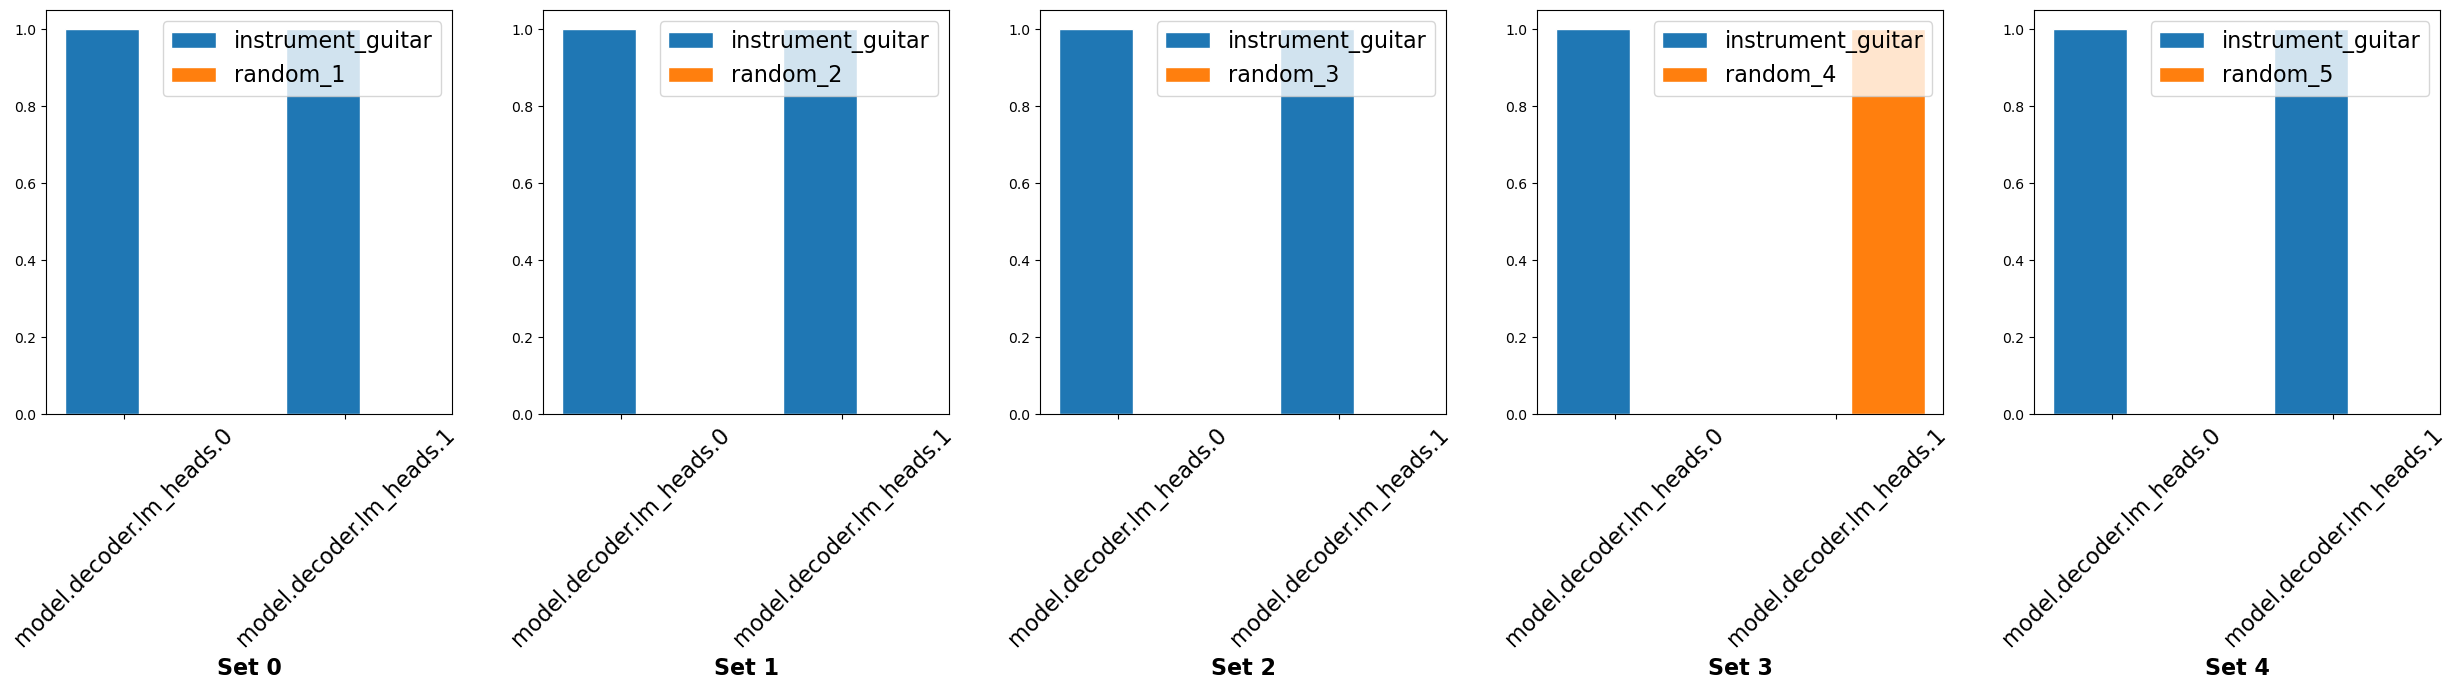

In [ ]:
plot_tcav_scores(experimental_set, tcav_scores)